In [4]:
from datetime import date
from glob import glob
import os, sys
from os.path import join, dirname
import pickle as pkl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.multitest
from matplotlib.colors import LinearSegmentedColormap

In [5]:
import scipy.stats
from scipy import optimize

In [6]:
import nilearn
from nilearn import plotting

/home/sungbeenpark/anaconda3/envs/GA/lib/python3.9/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [7]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

In [8]:
# To make plots using Matplotlib, you must first enable IPython's matplotlib mode.
# To do this, run the %matplotlib magic command to enable plotting in the current Notebook.
# This magic takes an optional argument that specifies which Matplotlib backend should be used. 
# Most of the time, in the Notebook, you will want to use the inline backend,
# which will embed plots inside the Notebook:
%matplotlib inline

In [9]:
dir_root = '/mnt/sdb2/GL/fmri_data'
dir_glm = join(dir_root, 'stats/GLM.reward')
dir_mask = join(dir_root, 'masks')

In [10]:
list_subj = [
    'GL03', 'GL04', 'GL05', 'GL06', 'GL07'
    , 'GL08', 'GL09', 'GL10', 'GL11', 'GL12'
    , 'GL14', 'GL15', 'GL16', 'GL17', 'GL18'
    , 'GL19', 'GL20', 'GL21', 'GL22', 'GL24'
    , 'GL25', 'GL26', 'GL27', 'GL29'
]

---

In [8]:
subj = 'GL05'

In [9]:
# ## full mask
# img_full_mask = nilearn.image.load_img(join(dir_glm, subj, 'full_mask.%s+orig.nii'%subj))

# ## striatum
# img_straitum = nilearn.image.load_img(join(dir_glm, subj, '%s.striatum.nii'%subj))

/home/sungbeenpark/anaconda3/envs/GA/lib/python3.9/site-packages/nilearn/image/resampling.py:273: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn("Resampling binary images with continuous or "



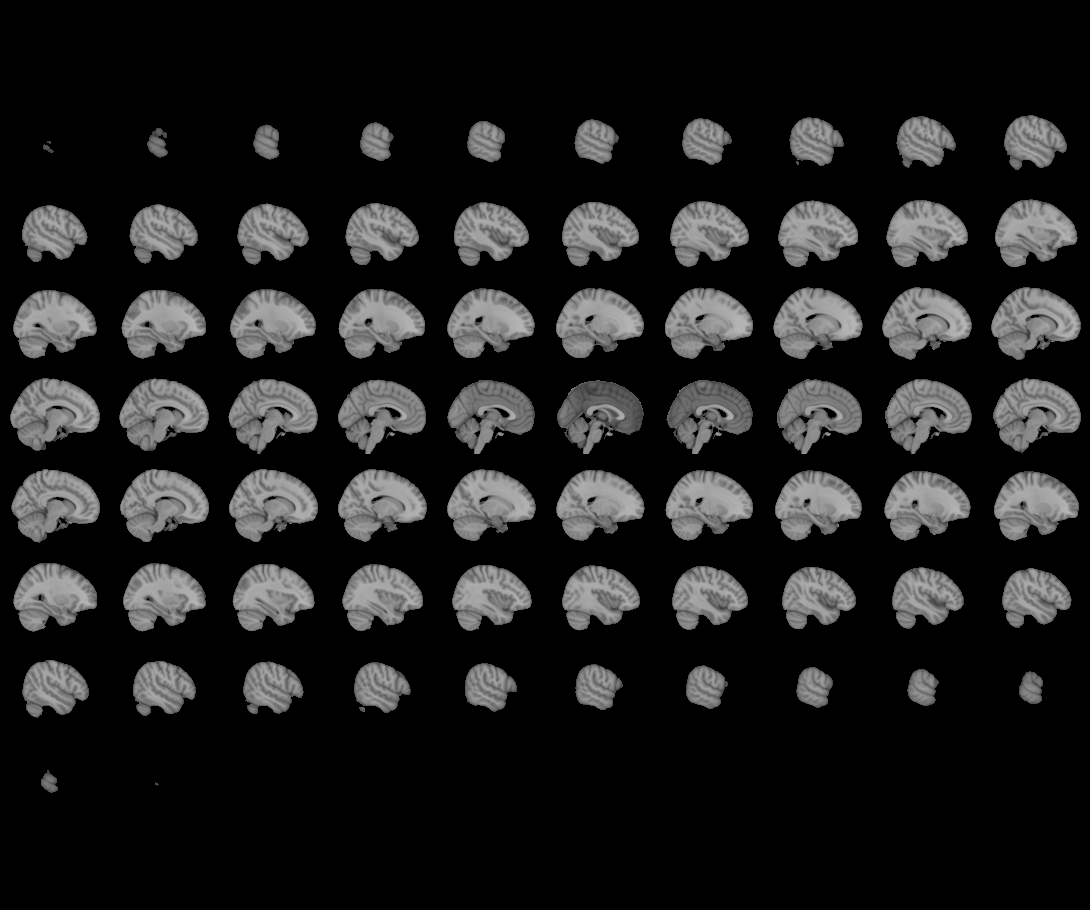
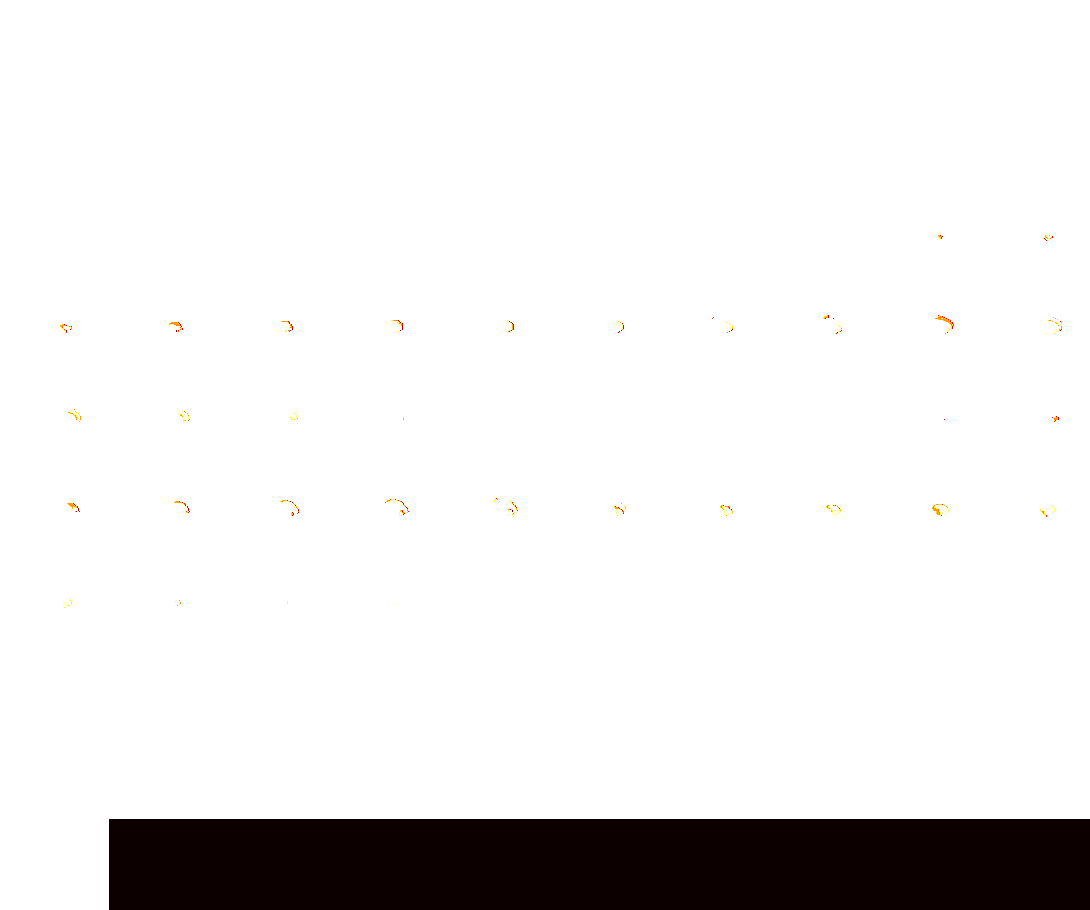

In [10]:
nilearn.plotting.view_img(join(dir_glm, subj, '%s.striatum.orig.nii'%subj))

Beta

#1. perterbation

[(-2.5, 2.5)]

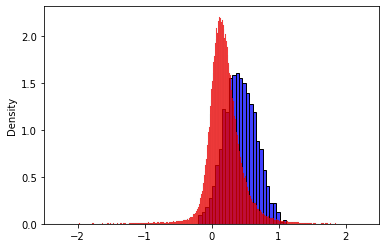

In [11]:
fig, ax = plt.subplots()

prop = 'Rew#1_Coef'
## within Striatum
img_masked = nilearn.masking.apply_mask(
    imgs=join(dir_glm, subj, '%s.%s.orig.nii'%(subj, prop))
    , mask_img=join(dir_glm, subj, '%s.striatum.orig.nii'%subj)
)
sns.histplot(img_masked, stat='density', color='blue', ax=ax)

## except Striatum
img_masked = nilearn.masking.apply_mask(
    imgs=join(dir_glm, subj, '%s.%s.orig.nii'%(subj, prop))
    , mask_img=join(dir_glm, subj, '%s.reverse.striatum.orig.nii'%subj)
)
sns.histplot(img_masked, stat='density', color='red', ax=ax)

ax.set(xlim=(-2.5, 2.5))

In [12]:
def standardize(array1D, with_mean=True, with_std=True):
    mu, std = 0, 1
    if with_mean:
        mu = np.mean(array1D)
    if with_std:
        std = np.std(array1D)
    result = (np.array(array1D) - mu)/std
    return result

#2. t-value

[(-10.0, 10.0)]

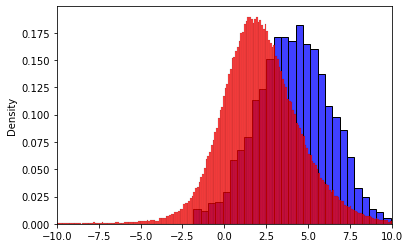

In [13]:
fig, ax = plt.subplots()

prop = 'Rew#1_Tstat'
## within Striatum
img_masked = nilearn.masking.apply_mask(
    imgs=join(dir_glm, subj, '%s.%s.orig.nii'%(subj, prop))
    , mask_img=join(dir_glm, subj, '%s.striatum.orig.nii'%subj)
)
sns.histplot(img_masked, stat='density', color='blue', ax=ax)
## except Striatum
img_masked = nilearn.masking.apply_mask(
    imgs=join(dir_glm, subj, '%s.%s.orig.nii'%(subj, prop))
    , mask_img=join(dir_glm, subj, '%s.reverse.striatum.orig.nii'%subj)
)
sns.histplot(img_masked, stat='density', color='red', ax=ax)

ax.set(xlim=(-10, 10))

True Positive: $MAP_{striatum} \cap MAP_{fMRI}$\
False Positive: $MAP^{c}_{striatum} \cap MAP_{fMRI}$\
True Negative: $MAP^{c}_{striatum} \cap MAP^{c}_{fMRI}$\
False Negative: $MAP_{striatum} \cap MAP^{c}_{fMRI}$

---

3dttest++

In [43]:
prop = 'Rew#1_Coef'
imgs_masked = np.ones((24, 4703)) * np.nan

for i, subj in enumerate(list_subj):
    imgs_masked[i] = nilearn.masking.apply_mask(
        imgs=join(dir_glm, subj, '%s.%s.tlrc.nii'%(subj, prop))
        , mask_img=join(dir_mask, 'mask.striatum.GL.nii')
    )

img_masked = nilearn.masking.apply_mask(
    imgs=join(dir_glm, 'group.beta_coef.GL.nii')
    , mask_img=join(dir_mask, 'mask.striatum.GL.nii')
)

## voxel-wise beta mean
img_masked[0,0] - imgs_masked.mean(axis=0)

array([-4.56930138e-09,  7.50878826e-09,  1.90145026e-09, ...,
        1.62981451e-09, -2.40591665e-09,  4.97190438e-10])

In [73]:
prop = 'Rew#1_Coef'
imgs_masked = np.ones((24, 4703)) * np.nan

for i, subj in enumerate(list_subj):
    imgs_masked[i] = nilearn.masking.apply_mask(
        imgs=join(dir_glm, subj, '%s.%s.tlrc.nii'%(subj, prop))
        , mask_img=join(dir_mask, 'mask.striatum.GL.nii')
    )

In [74]:
tval, pval = scipy.stats.ttest_1samp(imgs_masked, popmean=0, axis=0)
tval.shape

(4703,)

In [75]:
img_masked = nilearn.masking.apply_mask(
    imgs=join(dir_glm, 'group.beta_coef.GL.nii')
    , mask_img=join(dir_mask, 'mask.striatum.GL.nii')
)
img_masked.shape

(2, 1, 4703)

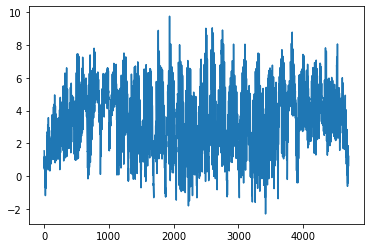

In [80]:
plt.plot(tval)

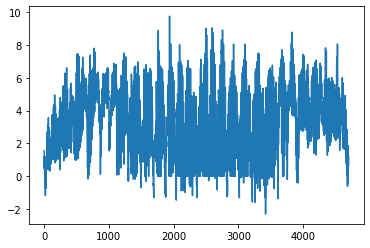

In [81]:
plt.plot(img_masked[1,0])

---

In [11]:
img_full_mask = nilearn.image.load_img('/mnt/ext6/GL/fmri_data/masks/full_mask.GL+tlrc.nii')
img_full_mask.shape

(96, 114, 96)

In [12]:
img_group = nilearn.image.load_img('/mnt/ext6/GL/fmri_data/stats/GLM.reward/GL.reward.group.Zscore.n24.nii')
img_group.shape

(96, 114, 96)

In [13]:
img_striatum = nilearn.image.load_img('/mnt/ext6/GL/fmri_data/masks/mask.striatum.nii')
img_striatum.shape

(96, 114, 96)

In [33]:
TPR = []
FPR = []
for threshold in np.linspace(start=-8., stop=8., num=33):
    ## True Positive
    TP = img_group.get_fdata()[img_striatum.get_data()>0]
    TP = TP[TP >= threshold]

    ## False Positive (full_mask>0 & striatum==0 -> reverse straitum)
    FP = img_group.get_fdata()[(img_full_mask.get_data()>0)&(img_striatum.get_data()==0)]
    FP = FP[FP >= threshold]

    ## True Negative
    TN = img_group.get_fdata()[(img_full_mask.get_data()>0)&(img_striatum.get_data()==0)]
    TN = TN[TN < threshold]

    ## False Negative
    FN = img_group.get_fdata()[img_striatum.get_data()>0]
    FN = FN[FN < threshold]

    TPR.append(TP.shape[0]/(FN.shape[0]+TP.shape[0]))
    FPR.append(FP.shape[0]/(TN.shape[0]+FP.shape[0]))

/tmp/ipykernel_1295462/932796788.py:5: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  TP = img_group.get_fdata()[img_striatum.get_data()>0]
/tmp/ipykernel_1295462/932796788.py:9: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  FP = img_group.get_fdata()[(img_full_mask.get_data()>0)&(img_striatum.get_data()==0)]
/tmp/ipykernel_1295462/932796788.py:13: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtai

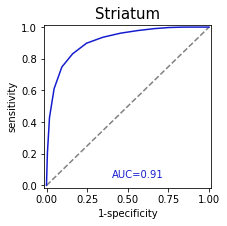

In [34]:
fig, ax = plt.subplots(figsize=(3,3))

ax.plot([0,1],[0,1], ls='--', color='gray')
ax.plot(FPR, TPR, '-', color='#151CD0')
ax.set(ylabel="sensitivity", xlabel="1-specificity")
ax.set(xlim=(-.015,1.015), ylim=(-0.015,1.015))
ax.set_title('Striatum', fontsize=15)

## AUC
AUC = 0
for ii in range(len(FPR)-1):
    x1, x2 = FPR[ii+1], FPR[ii]
    y1, y2 = TPR[ii+1], TPR[ii]
    area = (y1+y2)*(x2-x1)*0.5
    AUC += area

ax.text(0.4, 0.05, 'AUC=%.2f'%AUC, color='#151CD0')

fig.savefig(
    '/home/sungbeenpark/Github/labs/GL/results/GL.GLM.ROC_curve.png'
    , dpi=300, facecolor=[1,1,1,1]
    , bbox_inches = "tight"
)

---

In [21]:
df_TPR = pd.DataFrame()
df_FPR = pd.DataFrame()

/tmp/ipykernel_187803/2224314702.py:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  TP = img_tstat.get_fdata()[img_straitum.get_data()>0]
/tmp/ipykernel_187803/2224314702.py:27: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  FP = img_tstat.get_fdata()[(img_full_mask.get_data()>0)&(img_straitum.get_data()==0)]
/tmp/ipykernel_187803/2224314702.py:31: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obt

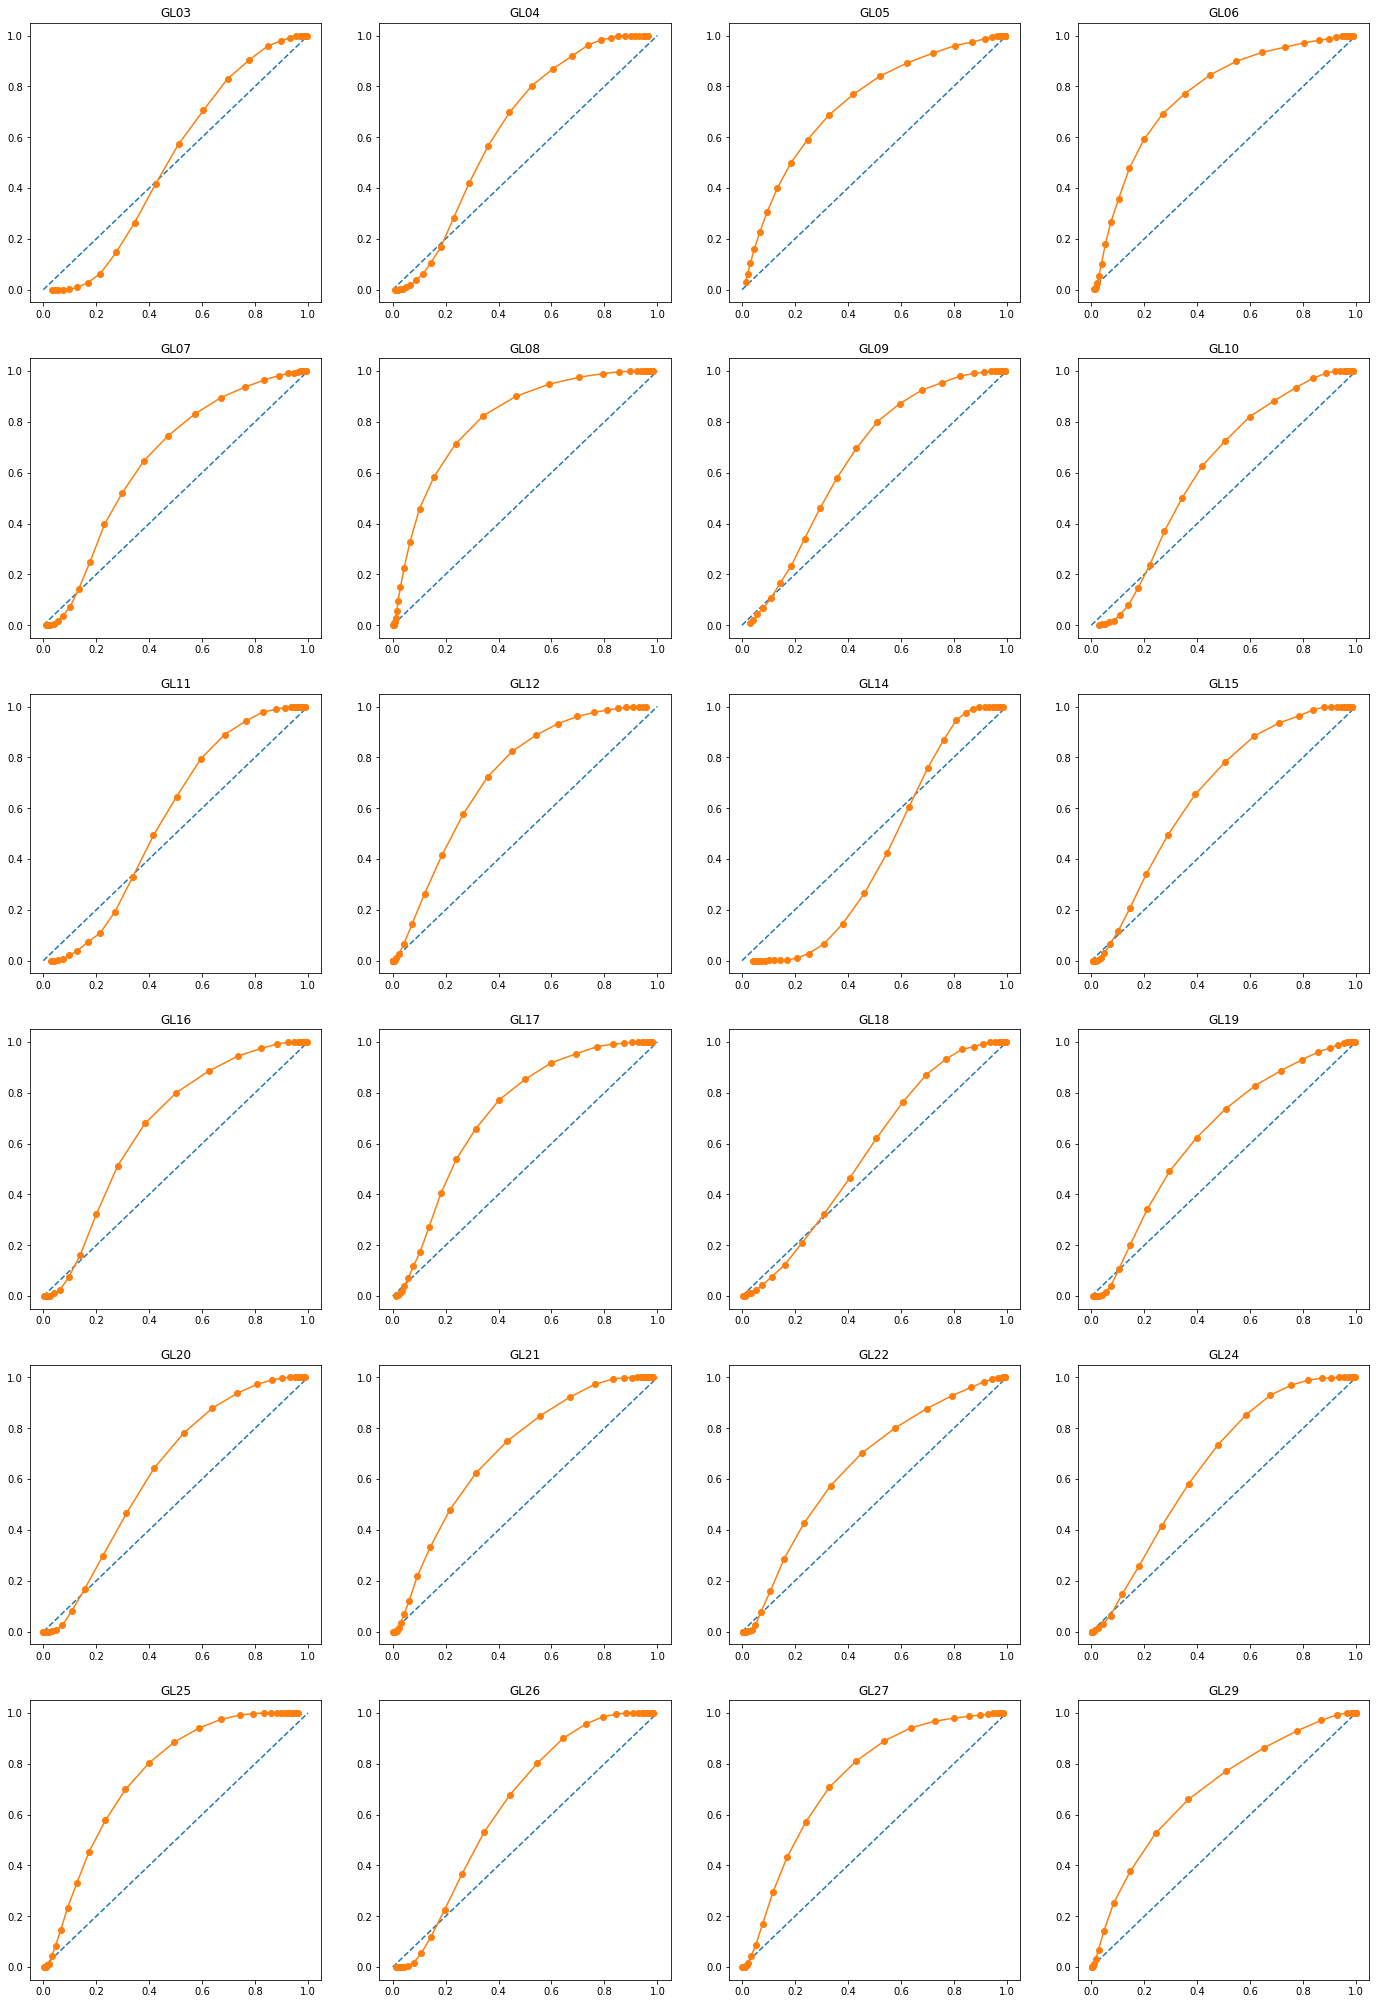

In [22]:
nrows=6
ncols=4
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*6, nrows*6))
axs = np.concatenate(axs)

for ii, subj in enumerate(list_subj):
    ax = axs[ii]
    
    ## full mask
    img_full_mask = nilearn.image.load_img(join(dir_glm, subj, 'full_mask.%s+orig.nii'%subj))

    ## striatum
    img_straitum = nilearn.image.load_img(join(dir_glm, subj, '%s.striatum.orig.nii'%subj))

    ## t-value
    prop = 'Rew#1_Tstat'
    img_tstat = nilearn.image.load_img(join(dir_glm, subj, '%s.%s.orig.nii'%(subj, prop)))

    TPR = []
    FPR = []
    for threshold in np.linspace(start=-8, stop=8., num=30):
        ## True Positive
        TP = img_tstat.get_fdata()[img_straitum.get_data()>0]
        TP = TP[TP >= threshold]

        ## False Positive00
        FP = img_tstat.get_fdata()[(img_full_mask.get_data()>0)&(img_straitum.get_data()==0)]
        FP = FP[FP >= threshold]

        ## True Negative
        TN = img_tstat.get_fdata()[(img_full_mask.get_data()>0)&(img_straitum.get_data()==0)]
        TN = TN[TN < threshold]

        ## False Negative
        FN = img_tstat.get_fdata()[img_straitum.get_data()>0]
        FN = FN[FN < threshold]

        TPR.append(TP.shape[0]/(FN.shape[0]+TP.shape[0]))
        FPR.append(1. - TN.shape[0]/(TN.shape[0]+FP.shape[0]))
        
    df_TPR[subj] = TPR
    df_FPR[subj] = FPR
    
    ax.plot([0,1],[0,1], ls='--')
    ax.plot(FPR, TPR, 'o-')
    ax.set(title=subj)

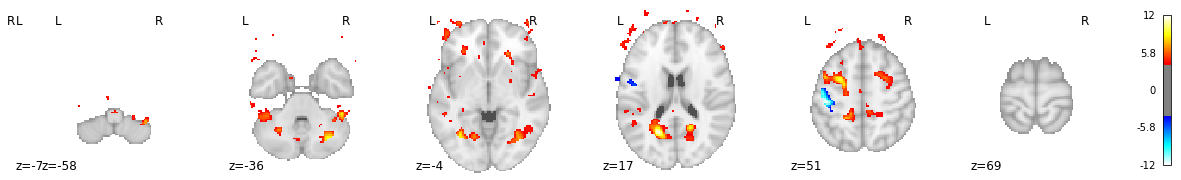

In [23]:
prop = 'Rew#1_Tstat'
nilearn.plotting.plot_stat_map(
    join(dir_glm, subj, '%s.%s.orig.nii'%(subj, prop))
    , display_mode='z', threshold=4.
)

In [ ]:
def func_test(x, a, b):
    return a * np.sin(b * x)